In [1]:
'''0208  新版特徵做預測'''
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
import pylab as plot

a = '新特徵資料_noerror.csv'
data = np.genfromtxt(a, dtype = None, delimiter = ',', skip_header = 0, filling_values = 0, invalid_raise = False, encoding = 'latin-1')
[Row,Column] = data.shape
print(data[0:2,:])

[[ 1.00000000e+02  4.00833326e+00 -2.33000000e-01  1.17000000e+03
   8.00690000e+00  1.50000000e+03  8.75000000e+00]
 [ 1.00000000e+02  4.00833326e+00 -2.14000000e-01  1.23000000e+03
   7.99290000e+00  1.71000000e+03  8.67000000e+00]]


In [2]:
features_train2, features_test2, soh_train2, soh_test2 = train_test_split(data[:,[1,2,3,4,5,6]], data[:,0:1].ravel(), test_size=0.2, random_state=100)
print("features_train2\n", features_train2)
print("soh_train2\n", soh_train2)     #檢查格式是否正確,才不會讓ML程式垮掉

features_train2
 [[ 3.51902772e+00 -2.62000000e-01  7.28000000e+02  8.11000000e+00
   1.31000000e+03  8.76000000e+00]
 [ 2.33638891e+00 -3.26000000e-01  1.79000000e+02  8.77340000e+00
   7.01000000e+02  8.89000000e+00]
 [ 3.01347228e+00 -3.20000000e-01  6.82000000e+02  8.24990000e+00
   1.08000000e+03  8.88000000e+00]
 ...
 [ 3.99027782e+00 -2.10000000e-01  8.12000000e+02  8.07800000e+00
   1.50000000e+03  8.66000000e+00]
 [ 3.36375000e+00 -2.54000000e-01  7.42000000e+02  8.12910000e+00
   1.31000000e+03  8.74000000e+00]
 [ 3.20847228e+00 -2.49000000e-01  6.95000000e+02  8.17880000e+00
   1.05000000e+03  8.75000000e+00]]
soh_train2
 [85.4 42.5 72.7 ... 96.  82.5 76.1]


In [25]:
import time
t1 = time.monotonic()

from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

reg = GradientBoostingRegressor(learning_rate=0.05, n_estimators=2000, random_state=0)
reg.fit(features_train2, soh_train2)
prediction = reg.predict(features_test2)

R_sq = np.round(reg.score(features_test2, soh_test2),3)
MAE = np.round(mean_absolute_error(prediction, soh_test2),3)
RMSE = np.round(np.sqrt(mean_squared_error(prediction,soh_test2)),3)
Residualss = np.array(prediction)-np.array(soh_test2)
print("R_sq = ", R_sq)
print(" MAE = ", MAE)
print("RMSE = ", RMSE)
print("Residualss = ", Residualss)

t2 = time.monotonic()
print("\ntime elapsed:" + str(np.round(t2-t1,3)) + " seconds")

R_sq =  0.985
 MAE =  1.569
RMSE =  2.211
Residualss =  [ 0.82907086  1.59829457  3.0508016  ... -0.26460563 -0.49240544
  2.59225732]

time elapsed:45.812 seconds


low_ci_bound
 [48.99571616 51.56493987 74.3174469  ... 35.50203967 85.27423986
 83.35890263]
high_ci_bound
 [57.66242556 60.23164927 82.9841563  ... 44.16874907 93.94094926
 92.02561202]
std of the SOH
  =  0.253


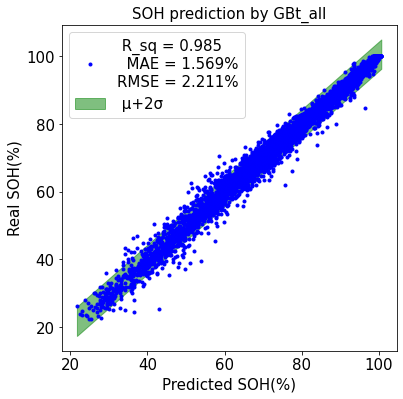

In [27]:
import seaborn as sns
import matplotlib
import scipy.stats as st
matplotlib.rcParams.update({'font.size': 20})

# predicted expect and calculte confidence interval
low_ci_bound, high_ci_bound = st.t.interval(0.95, len(prediction),
                                           loc=prediction, scale=Residualss.std())   #st.sem(y_test_pred_array)
print("low_ci_bound\n", low_ci_bound)
print("high_ci_bound\n", high_ci_bound)
print("std of the SOH\n  = ", np.round(st.sem(prediction),3))

# plot confidence interval
plt.figure(figsize=(6,6))   #, color='green', linestyle='dashed', linewidth = 3, marker='o',
plt.plot(prediction, soh_test2, color='blue', linestyle='None' , marker='.', label=f' R_sq = {R_sq}\n  MAE = {MAE}%\nRMSE = {RMSE}%')   #, 'b.'
plt.fill_between(sorted(prediction), sorted(low_ci_bound), sorted(high_ci_bound), color='green', alpha=0.5,
                label=' μ+2σ')
plt.xlabel("Predicted SOH(%)", fontsize=15) 
plt.ylabel("Real SOH(%)", fontsize=15)
plt.tick_params(labelsize=15)
plt.legend(fontsize=15)
plt.title("SOH prediction by GBt_all", fontsize=15)
#plt.grid()
plt.show()

Sampling Mean: 0.033
Sampling StdErr: 2.210
95% Confidence Interval: [-4.299  4.365]


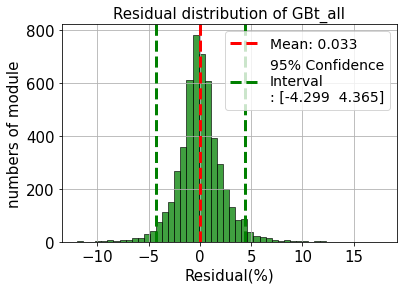

In [28]:
'''Residuals'''
from scipy import stats

# 取得 X_mean 的 mean, std, 95% 信賴區間
m = Residualss.mean()                  # X_bar 的平均
se = Residualss.std()                  # 標準誤
ci = np.round(stats.norm.interval(0.95, m, se),3)   # return [m - 1.96 std, m + 1.96 std]

print (f'Sampling Mean: {m:.3f}')
print (f'Sampling StdErr: {se:.3f}')
print (f'95% Confidence Interval: {ci}')

sns.histplot(Residualss, color='green', bins=50, kde=False)
plt.axvline(m, color='red', linestyle='dashed', linewidth=3, label=f'Mean: {m:.3f}')
plt.axvline(ci[0], color='green', linestyle='dashed', linewidth=3, label=f'95% Confidence\nInterval\n: {ci}')
plt.axvline(ci[1], color='green', linestyle='dashed', linewidth=3)
plt.xlabel('Residual(%)', fontsize=15)
plt.ylabel('numbers of module', fontsize=15)
plt.tick_params(labelsize=15)
plt.title('Residual distribution of GBt_all', fontsize=15)
plt.legend(fontsize=14); plt.grid(); plt.show()

Sampling Mean: 0.003
Sampling StdErr: 0.042
95% Confidence Interval: [-0.08   0.085]


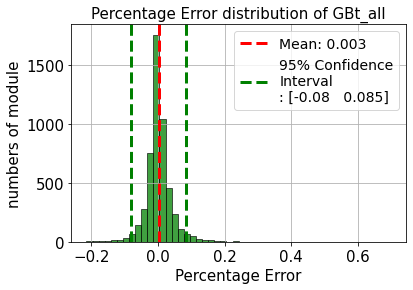

In [29]:
'''Percentage Error'''
pep_fnn = Residualss/soh_test2

# 取得 X_mean 的 mean, std, 95% 信賴區間
m3 = pep_fnn.mean()                  # X_bar 的平均
se3 = pep_fnn.std()                  # 標準誤
ci3 = np.round(stats.norm.interval(0.95, m3, se3),3)   # return [m - 1.96 std, m + 1.96 std]

print (f'Sampling Mean: {m3:.3f}')
print (f'Sampling StdErr: {se3:.3f}')
print (f'95% Confidence Interval: {ci3}')

sns.histplot(pep_fnn, color='green', bins=50, kde=False)
plt.axvline(m3, color='red', linestyle='dashed', linewidth=3, label=f'Mean: {m3:.3f}')
plt.axvline(ci3[0], color='green', linestyle='dashed', linewidth=3, label=f'95% Confidence\nInterval\n: {ci3}')
plt.axvline(ci3[1], color='green', linestyle='dashed', linewidth=3)
plt.xlabel('Percentage Error', fontsize=15)
plt.ylabel('numbers of module', fontsize=15)
plt.tick_params(labelsize=15)
plt.title('Percentage Error distribution of GBt_all', fontsize=15)
plt.legend(fontsize=14); plt.grid(); plt.show()

# Gradient Boosting

[100.  100.  100.  ...  68.2  83.1  92.1]
predvalue =  [array([71.43332991, 71.72505863, 73.9734141 , ..., 69.82075739,
       71.43332991, 72.26765662]), array([69.98368153, 70.45296271, 74.36235112, ..., 66.4870334 ,
       69.98368153, 71.28154063]), array([68.31623481, 69.14811698, 74.97662931, ..., 63.61030584,
       68.67883579, 70.35375008]), array([66.83667264, 67.87101331, 75.46265054, ..., 60.47671874,
       67.19927362, 70.11105347]), array([65.60705106, 66.64139173, 75.65772813, ..., 58.15953722,
       65.96965204, 69.79779067]), array([64.50276283, 65.99095353, 76.02933233, ..., 55.99302772,
       64.86536381, 69.33701663]), array([63.49200577, 65.25497666, 76.5056381 , ..., 53.64156815,
       64.12938694, 69.01755851]), array([62.67295532, 64.80923629, 76.76243642, ..., 51.88974682,
       63.31033649, 68.57181814]), array([61.72984925, 64.21745381, 76.9322941 , ..., 50.13464388,
       62.71855401, 68.37325024]), array([60.75745296, 63.71368877, 76.99847409, ..., 48

ValueError: x and y must have same first dimension, but have shapes (2870, 2555) and (2555,)

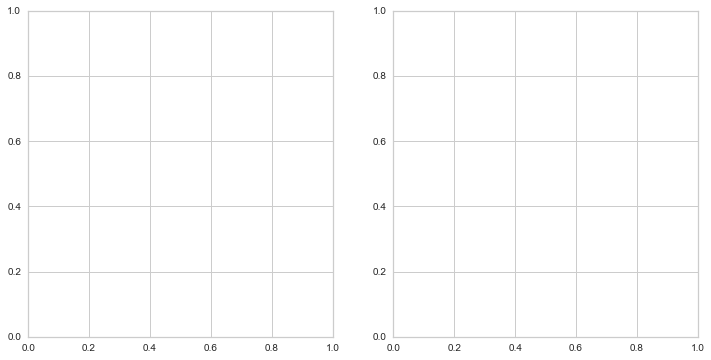

In [150]:
'''1121 Gradient Boosting'''
import torch
from torch import nn, optim
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
import pylab as plot

filename = "ML_noerror.csv"     # print(data)
data = np.genfromtxt(filename, delimiter = ',', dtype = None, skip_header = 0, encoding = 'UTF-8')     #, usecols = [7,15,37,38,53]
[Row,Column] = data.shape     # 確認data(?)...print(data.shape); print(data); print(type(data[1,0]))
fts = data[:,1:6]
soh = data[:,0:1]
soh2 = [];
for i in range(len(soh)):
    soh2.append(soh[i][0].astype(np.float64))
pred_soh = np.array(soh2)
features_train, features_test, pred_soh_train, pred_soh_test = train_test_split(fts, pred_soh.ravel(), test_size=0.1, random_state=100)
print(pred_soh)     # 驗證是否當機

rmseoos = []
maeoos = []
predvalue = []
'''超參數 (每次訓練完要複製)'''
variables = range(10, 410, 30)
for variable in variables:
    # nest = 200
    depth = 5
    learnrate = 0.1
    subsamp = 0.5
    model = ensemble.GradientBoostingRegressor(n_estimators=variable, max_depth=depth, learning_rate=learnrate, subsample = subsamp, loss='squared_error')
    model.fit(features_train, pred_soh_train)
    predictions = model.staged_predict(features_test)
    for p in predictions:
        predvalue.append(p)
        rmseoos.append(math.sqrt(mean_squared_error(pred_soh_test, p)))
        maeoos.append(mean_absolute_error(pred_soh_test, p))
R_sq = np.round(model.fit(features_train, pred_soh_train).score(features_test, pred_soh_test),3)
print("predvalue = ", predvalue)
print("   R_sq = ", R_sq)
print(" MAE(%) = ", np.round(maeoos[-1],3))
print("RMSE(%) = ", np.round(rmseoos[-1],3))
print("Lowest RMSE(%) = ", np.round(min(rmseoos),3))
print("Optimal place = ", rmseoos.index(min(rmseoos)))

f = plot.figure(figsize=(12,6))
ax1 = f.add_subplot(121); ax2 = f.add_subplot(122)

ax1.plot(predvalue,pred_soh_test, 'b.')
m1, b1 = np.polyfit(predvalue,pred_soh_test, 1);
ax1.axline(xy1=(0, b1), slope=m1, color='g', label=f'R_sq   = {R_sq}\n   MAE = {MAE}%\nRMSE = {RMSE}%') # 
ax1.set_xlabel("Predicted SOH(%)", fontsize=15) 
ax1.set_ylabel("Real SOH(%)", fontsize=15)
ax1.legend(fontsize=15)

ax2.plot(variables, rmseoos)
ax2.set_xlabel("random_state_labels", fontsize=18) 
ax2.set_ylabel("RMSE(%)", fontsize=18)

In [151]:
print("predvalue[0] = ", predvalue[0])

predvalue[0] =  [71.43332991 71.72505863 73.9734141  ... 69.82075739 71.43332991
 72.26765662]


C:\Users\Chun-Po\miniconda3\envs\env_pytorch\lib\site-packages\sklearn\ensemble\_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


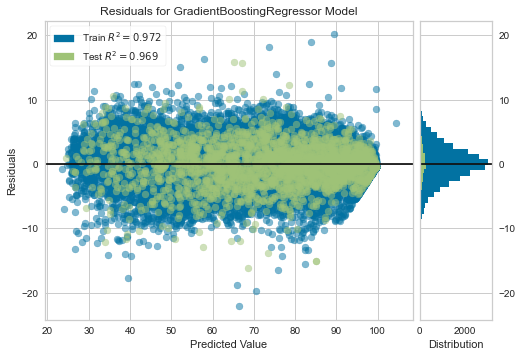

<AxesSubplot:title={'center':'Residuals for GradientBoostingRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [133]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(model.fit(features_train, pred_soh_train),train_alpha=0.5, test_alpha=0.5)
visualizer.fit(features_train, pred_soh_train)
visualizer.score(features_test, pred_soh_test)
visualizer.poof()

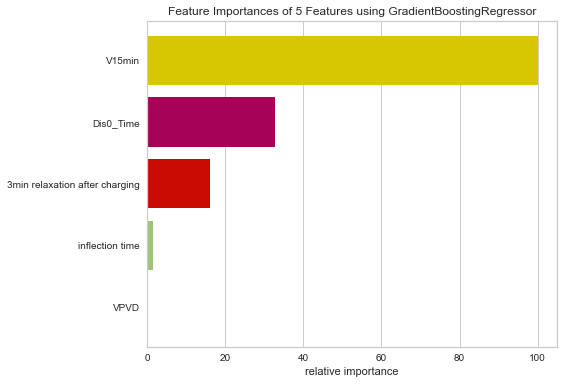

<AxesSubplot:title={'center':'Feature Importances of 5 Features using GradientBoostingRegressor'}, xlabel='relative importance'>

In [129]:
'''特徵在訓練模型時的重要性'''
from yellowbrick.model_selection import FeatureImportances
visualizer = FeatureImportances(model,labels=["3min relaxation after charging","inflection time","V15min","Dis0_Time","VPVD"])
visualizer.fit(features_train, pred_soh_train)
visualizer.show()

# Random forest

RMSE(%) =  2.742
time elapsed:323.53 seconds


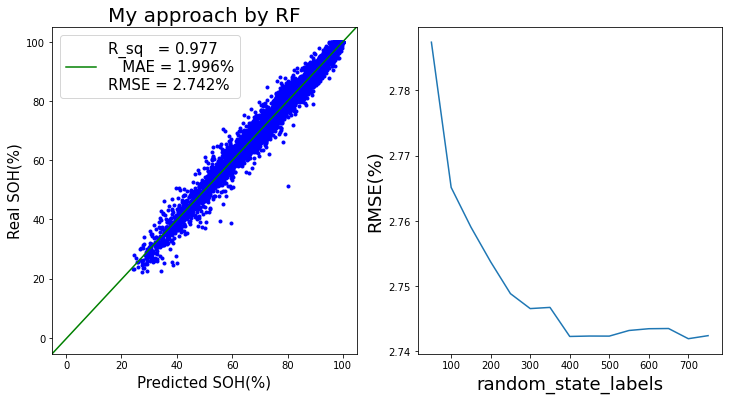

In [1]:
'''1115 Random Forest'''
import torch
from torch import nn, optim
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
import pylab as plot
import time

t1 = time.monotonic()

'''輸入資料並分割資料集'''
filename = "ML_noerror.csv"
data = np.genfromtxt(filename, delimiter = ',', dtype = None, skip_header = 0, encoding = 'UTF-8')
[Row,Column] = data.shape
fts = data[:,1:6]
soh = data[:,0:1]
soh2 = [];
for i in range(len(soh)):
    soh2.append(soh[i][0].astype(np.float64))
pred_soh = np.array(soh2)
features_train, features_test, pred_soh_train, pred_soh_test = train_test_split(fts, pred_soh.ravel(), test_size=0.2, random_state=100)

'''調整超參數並衡量訓練效果。以下示範"森林中的樹木量"不同時,模型損失的變化'''
rmseoos = []
ntreelist = range(50, 800, 50)
for itrees in ntreelist:
    depth = None
    maxfeat = 2
    model = ensemble.RandomForestRegressor(n_estimators=itrees, max_depth=depth, max_features=maxfeat, oob_score=False, random_state=100)
    model.fit(features_train, pred_soh_train)
    predictions = model.predict(features_test)
    rmseoos.append(math.sqrt(mean_squared_error(pred_soh_test, predictions)))
R_sq = np.round(model.fit(features_train, pred_soh_train).score(features_test, pred_soh_test),3)
MAE = np.round(mean_absolute_error(predictions,pred_soh_test),3)
RMSE = np.round(np.sqrt(mean_squared_error(predictions,pred_soh_test)),3)
print("RMSE(%) = ", RMSE)

time elapsed:593.91 seconds


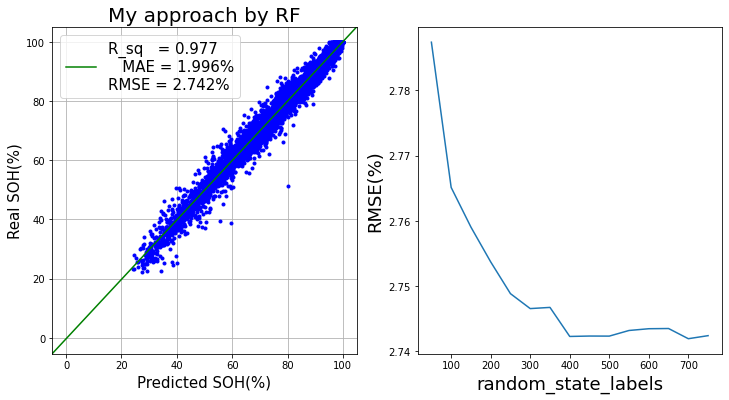

In [2]:
'''畫圖:最後一次調整的超參數，其訓練出來的預測值和實際值的擬合圖，以及不同超參數下的模型損失'''
f = plot.figure(figsize=(12,6))
ax1 = f.add_subplot(121); ax2 = f.add_subplot(122)

ax1.plot(predictions,pred_soh_test, 'b.');
ax1.set_title("My approach by RF", fontsize=20);
m1, b1 = np.polyfit(predictions,pred_soh_test, 1);
ax1.axline(xy1=(0, b1), slope=m1, color='g', label=f'R_sq   = {R_sq}\n   MAE = {MAE}%\nRMSE = {RMSE}%') # 
ax1.set_xlabel("Predicted SOH(%)", fontsize=15) 
ax1.set_ylabel("Real SOH(%)", fontsize=15)
ax1.grid()
ax1.legend(fontsize=15)

ax2.plot(ntreelist, rmseoos)
ax2.set_xlabel("random_state_labels", fontsize=18) 
ax2.set_ylabel("RMSE(%)", fontsize=18)

t2 = time.monotonic()
print("time elapsed:" + str(np.round(t2-t1,2)) + " seconds")

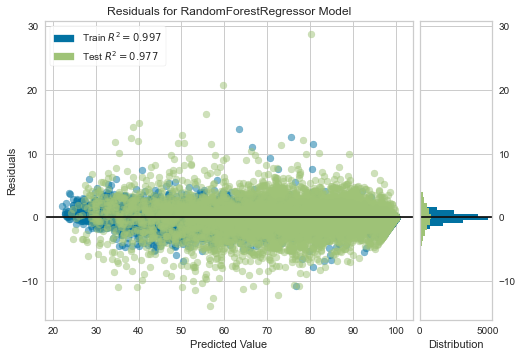

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [155]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(model.fit(features_train, pred_soh_train),train_alpha=0.5, test_alpha=0.5)
visualizer.fit(features_train, pred_soh_train)
visualizer.score(features_test, pred_soh_test)
visualizer.poof()

In [156]:
predictions_all = model.predict(fts)     # fts, pred_soh.ravel()
R_sq2 = np.round(r2_score(predictions_all, pred_soh),3)
MAE2 = np.round(mean_absolute_error(predictions_all, pred_soh),3)
RMSE2 = np.round(np.sqrt(mean_squared_error(predictions_all, pred_soh)),3)
print("R_sq2",R_sq2)
print("MAE2",MAE2)
print("RMSE2",RMSE2)

R_sq2 0.993
MAE2 0.987
RMSE2 1.529


Text(0, 0.5, 'RMSE(%)')

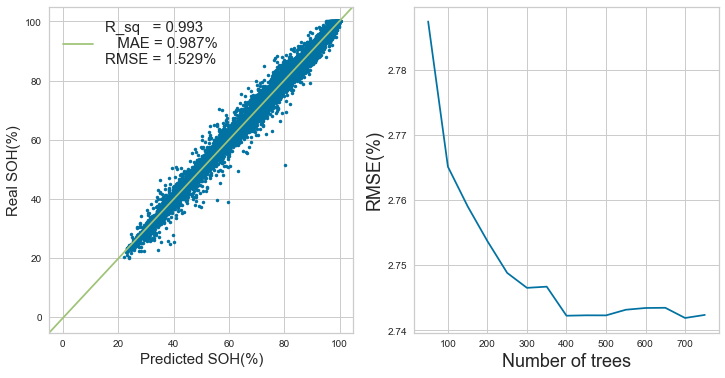

In [157]:
f = plot.figure(figsize=(12,6))
ax1 = f.add_subplot(121); ax2 = f.add_subplot(122)

ax1.plot(predictions_all, pred_soh, 'b.')
m1, b1 = np.polyfit(predictions_all, pred_soh, 1)
ax1.axline(xy1=(0, b1), slope=m1, color='g', label=f'R_sq   = {R_sq2}\n   MAE = {MAE2}%\nRMSE = {RMSE2}%'); # 
ax1.set_xlabel("Predicted SOH(%)", fontsize=15) 
ax1.set_ylabel("Real SOH(%)", fontsize=15)
ax1.legend(fontsize=15)

ax2.plot(ntreelist, rmseoos)
ax2.set_xlabel("Number of trees", fontsize=18) 
ax2.set_ylabel("RMSE(%)", fontsize=18)

ValueError: Expected 2D array, got 1D array instead:
array=[99.0596   99.88267  99.63893  ... 68.994934 83.36867  91.6944  ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

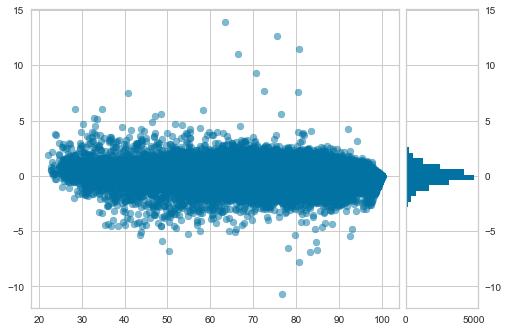

In [158]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(model.fit(features_train, pred_soh_train),train_alpha=0.5, test_alpha=0.5)
visualizer.fit(features_train, pred_soh_train)
visualizer.score(predictions_all, pred_soh)
visualizer.poof()

# 紀錄訓練成果

In [ ]:
'''紀錄訓練成果'''
(2022.1118.1550-1552)試驗random_state不同時的影響
RMSE(%) =  2.78；

(2022.1118.1509-1532)整理max_features = 2時不同樹木數對訓練成果的影響
RMSE(%) =  2.78；

(2022.1118.1440-1445)測試不同的max_features對訓練成效的影響
RMSE(%) =  2.785；max_features = 2時效果最優

(2022.1118.0913-0920)測試不同的depth對訓練成效的影響
RMSE(%) =  2.785；損失從樹深>14開始就不再明顯降低了

(2022.1117.1435-1440)重複執行最佳結果:max_features=2;樹木間距50;max_depth=None
RMSE(%) =  2.785
--------------------------------------------------------------------------------------------------------------------------------
(2022.1117.1316-1326)max_features=5; 樹木間距從10增加到50
RMSE(%) =  2.823

(2022.1116.1637-  )max_features=3
RMSE(%) =  2.791

(2022.1116.1316-  )再次降低max_features:=1
RMSE(%) =  2.846

(2022.1116.1156-  )降低max_features和樹木數量
RMSE(%) =  2.782

(2022.1115.1818-18  )最後一次擴大樹木數量
RMSE(%) = 2.799

(2022.1115.1530-15  )改測試組大小
RMSE(%) = 2.801

(2022.1115.14xx-14xx)
RMSE(%) = 2.834

(2022.1115.1137-1145)
RMSE(%) = 2.842

# 五個特徵之間的關係

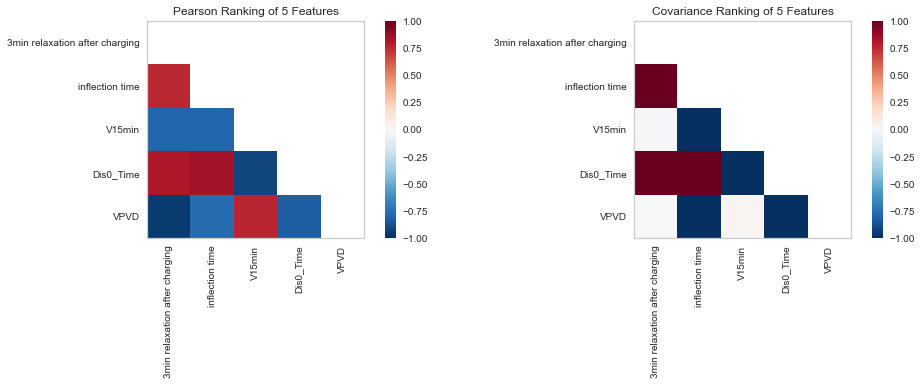

In [40]:
'''特徵之間的關係'''
from yellowbrick.features import rank2d

_, axes = plot.subplots(ncols=2, figsize=(16,4))

rank2d(features_train, algorithm="pearson",features=["3min relaxation after charging","inflection time","V15min","Dis0_Time","VPVD"], ax=axes[0], show=False)
rank2d(features_train, algorithm="covariance",features=["3min relaxation after charging","inflection time","V15min","Dis0_Time","VPVD"], ax=axes[1], show=False)
plot.show()


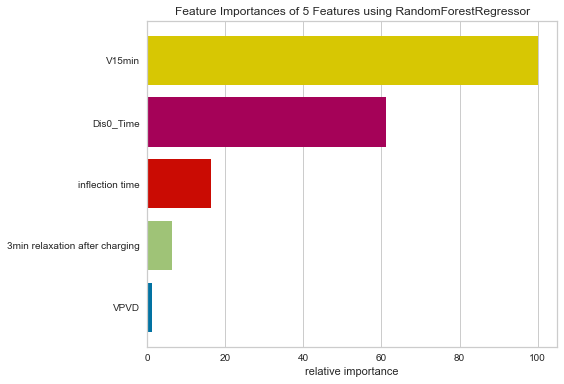

<AxesSubplot:title={'center':'Feature Importances of 5 Features using RandomForestRegressor'}, xlabel='relative importance'>

In [43]:
'''特徵在訓練模型時的重要性'''
from yellowbrick.model_selection import FeatureImportances
visualizer = FeatureImportances(model,labels=["3min relaxation after charging","inflection time","V15min","Dis0_Time","VPVD"])
visualizer.fit(features_train, pred_soh_train)
visualizer.show()


In [ ]:
------------------------------------------------------'''分隔區,練習codes'''-----------------------------------------------------

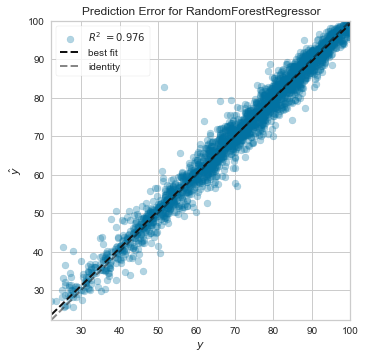

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [47]:
'''Plotting the prediction errors'''
from yellowbrick.regressor import PredictionError
visualizer = PredictionError(model.fit(features_train, pred_soh_train),alpha=0.3)
visualizer.fit(features_train, pred_soh_train)
visualizer.score(features_test, pred_soh_test)
visualizer.poof()

In [11]:
'''搞懂train_test_split如何分割'''
from sklearn.model_selection import train_test_split
data = [n for n in range(1, 21)]
print("Full data = ", data)
train_data, test_data = train_test_split(data, random_state=7, train_size=0.8)
print("Train data = ", train_data)
print("Test data = ", test_data)

Full data =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Train data =  [12, 1, 19, 7, 14, 20, 11, 15, 9, 17, 10, 13, 8, 4, 5, 16]
Test data =  [2, 18, 3, 6]


In [ ]:
'''書本實作/實例'''
import urllib2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
import pylab as plot

target_url = ("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv")
data = urlib2.urlopen(target_url)

xlist = []; labels = []; names = [];
firstline = True
for line in data:
    if firstline:
        names = line.strip().split(";")
        firstline = False
    else:
        row = line.strip().split(";")
        labels.append(float(row[-1]))
        row.pop()
        floatrow = [float(num) for num in row]
        xlist.append(floatrow)

nrows = len(xlist)
ncols = len(xlist[0])

x = 